# World cup 2018 group stages prediction

- Author: Tommy Lam

- Date: 19 June 2018

- Abstract: This model predicts the odds of matches in World Cup 2018 groupstages by using ELO model. The ELO model is developed by using the match data after World Cup 2014. 

# Packages install

In [1]:
# install.packages('dplyr')
# install.packages('elo')

# Import libraries

In [2]:
library(readr)
library(dplyr)
library(elo)
library(lubridate)
library(MLmetrics)
library(reshape2)

library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




# Read the data
The raw dataset includes the match results and odds from betfair of international tournament starting from 2000 to 2018 before the world cup started.

In [3]:
# Read in the world cup CSV data
setwd("~/DS/World Cup ELO Models")
rawdata_t = read_csv("wc_datathon_dataset.csv")
head(rawdata_t,3)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  team_1 = col_character(),
  team_2 = col_character(),
  team_1_goals = col_double(),
  team_2_goals = col_double(),
  tournament = col_character(),
  is_team_1_home = col_logical(),
  is_team_2_home = col_logical(),
  is_neutral = col_logical(),
  team_1_betfair_odds = col_double(),
  draw_betfair_odds = col_double(),
  team_2_betfair_odds = col_double()
)



date,team_1,team_2,team_1_goals,team_2_goals,tournament,is_team_1_home,is_team_2_home,is_neutral,team_1_betfair_odds,draw_betfair_odds,team_2_betfair_odds
<date>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
2000-06-10,Belgium,Sweden,2,1,Euro 2000,TRUE,FALSE,FALSE,2.72,2.90,3.3
2000-06-11,France,Denmark,3,0,Euro 2000,FALSE,FALSE,TRUE,1.68,3.75,6.6
2000-06-11,Netherlands,Czech Republic,1,0,Euro 2000,TRUE,FALSE,FALSE,1.80,3.45,5.9


In this ELO model, match results after World Cup 2014 will be selected. It is believed that the older match results giving less impacts to the current team performance. Also, the team formations and playing styles would be similar within 4 years.

In [4]:
#### Filter data from World Cup 2014 and reformat some columns for further analysis
#select training data to use: AFTER WC2014
training_t = rawdata_t %>%
  filter(
    # Match should occur after 2014 world cup
    date > rawdata_t %>% filter(tournament == "World Cup 2014") %>% pull(date) %>% max()
    # # Match should occur before 2014 world cup starts
    # date < rawdata %>% filter(tournament == "World Cup 2014") %>% pull(date) %>% min()
  ) %>% mutate(
            home_actual = ifelse(team_1_goals > team_2_goals, 1, 0),
            draw_actual = ifelse(team_1_goals == team_2_goals, 1, 0),
            away_actual = ifelse(team_2_goals > team_1_goals, 1, 0),
            elo_score = ifelse(team_1_goals > team_2_goals, 1, ifelse(team_1_goals == team_2_goals, 0.5, 0)),
            home = ifelse(is_team_1_home,1,0),
            neutral = ifelse(is_neutral,1,0)
       )
head(training_t,3)

date,team_1,team_2,team_1_goals,team_2_goals,tournament,is_team_1_home,is_team_2_home,is_neutral,team_1_betfair_odds,draw_betfair_odds,team_2_betfair_odds,home_actual,draw_actual,away_actual,elo_score,home,neutral
<date>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2014-07-19,Botswana,Guinea-Bissau,2,0,African Cup of Nations 2015 Qualifiers,TRUE,FALSE,FALSE,1.88,3.7,4.7,1,0,0,1,1,0
2014-07-19,Sierra Leone,Seychelles,2,0,African Cup of Nations 2015 Qualifiers,TRUE,FALSE,FALSE,1.19,8.4,18.0,1,0,0,1,1,0
2014-07-19,Uganda,Mauritania,2,0,African Cup of Nations 2015 Qualifiers,TRUE,FALSE,FALSE,1.46,4.7,8.8,1,0,0,1,1,0


## Investigation of Home advantage
The following is an investigation on the win rate due to home or neutral venue. 

In [5]:
####effect on home/away/neutral
# print('All data:')
all = round(colMeans(training_t[,13:18]),2)

# print('Home game')
home = round(colMeans(training_t[,13:18] %>% 
           filter(
             home == 1
           )),2)

# print('Neutral game')
neutral = round(colMeans(training_t[,13:18] %>% 
           filter(
             neutral == 1
           )),2)

home_adv = data.frame('All' = all,
           'Home' = home,
          'Neutral' = neutral
          )
home_adv = (home_adv[1:3,])

home_adv <- cbind(type = rownames(home_adv), home_adv)
rownames(home_adv) <- 1:nrow(home_adv)

home_adv = as.data.frame(home_adv)
home_adv = melt(home_adv[,c('type','All','Home','Neutral')],id.vars = 1)
home_adv

type,variable,value
<fct>,<fct>,<dbl>
home_actual,All,0.48
draw_actual,All,0.24
away_actual,All,0.28
home_actual,Home,0.50
draw_actual,Home,0.23
away_actual,Home,0.27
home_actual,Neutral,0.41
draw_actual,Neutral,0.25
away_actual,Neutral,0.34


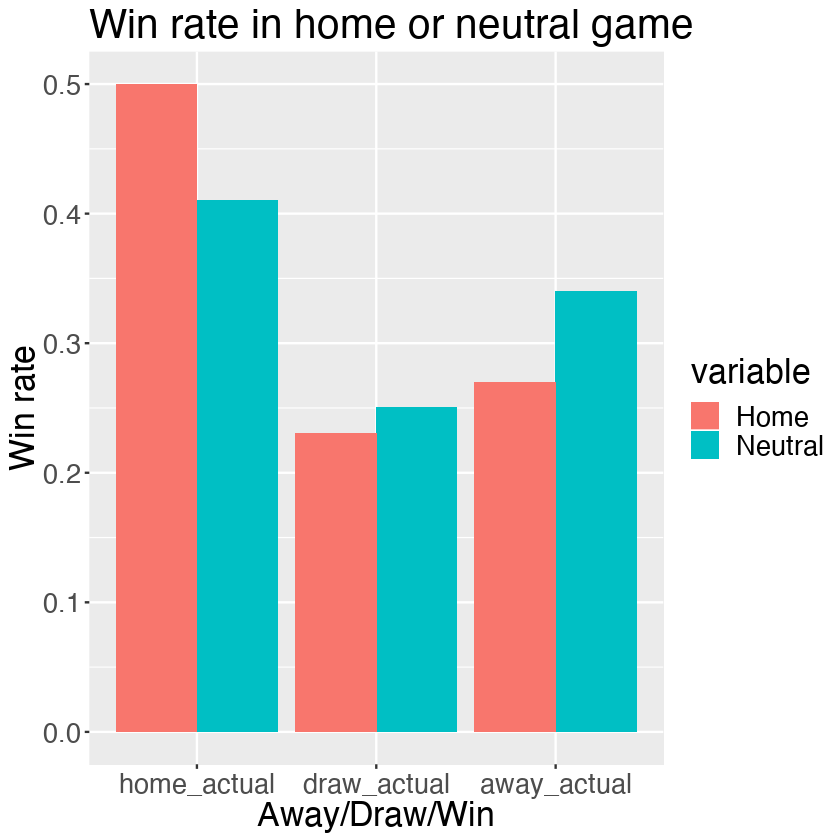

In [6]:
home_adv$type = factor(home_adv$type,levels = c("home_actual", "draw_actual", "away_actual"))
ggplot(data = home_adv[4:9,], aes(x = type , y= value , fill = variable))+
geom_bar(aes(group = (variable)), position = "dodge", stat = 'identity') +
labs(x='Away/Draw/Win',y='Win rate',title = 'Win rate in home or neutral game') +
theme(text = element_text(size=20))

### Correlation matrix :

In [7]:
####correlation
res <- cor(training_t[,13:18])
round(res, 2)

,home_actual,draw_actual,away_actual,elo_score,home,neutral
home_actual,1.00,-0.54,-0.60,0.91,0.07,-0.07
draw_actual,-0.54,1.00,-0.35,-0.13,-0.02,0.02
away_actual,-0.60,-0.35,1.00,-0.88,-0.06,0.06
elo_score,0.91,-0.13,-0.88,1.00,0.08,-0.08
home,0.07,-0.02,-0.06,0.08,1.00,-1.00
neutral,-0.07,0.02,0.06,-0.08,-1.00,1.00


## ELO score calculation

Define the function to calculate the winning probaility based on ELO score.

In [8]:
##probability function
win_prob = function(team1,team2) {
  prob = 1/(1+10^((team2-team1)/400))
  return(prob)
}

Initialise the scores as 1500:

In [9]:
##score for teams
score = data.frame(
  team = unique(c(training_t$team_1,training_t$team_2)),
  score = 1500
)


Main calculation:

In [10]:
## calculation
elo_t =  training_t %>% select(team_1, team_2, tournament, elo_score, home, neutral) %>%
  mutate(team_1_score=1500, team_2_score=1500,
         team_1_prob = 0, team_1_update = 0)

## Main loop
for (i in 1:nrow(elo_t)) {
  team1 = as.character(elo_t[i,'team_1'])
  team2 = as.character(elo_t[i,'team_2'])
  #obtain team score
  elo_t[i,'team_1_score'] = score[which(score$team == team1),2]
  elo_t[i,'team_2_score'] = score[which(score$team == team2),2]
  #define k
  k=30
  if (elo_t[i,'tournament'] == 'Friendly') { k = k*0.7 }
  if (elo_t[i,'home']==1 & elo_t[i,'elo_score']==1) {k=k*0.8}
  if (elo_t[i,'home']==1 & elo_t[i,'elo_score']==0) {k=k*1.2}
  
  #cal. score
  elo_t[i,'team_1_prob'] = win_prob(score[which(score$team == team1),2],score[which(score$team==team2),2])
  elo_t[i,'team_1_update'] = k*(elo_t[i,'elo_score']-elo_t[i,'team_1_prob'])
  #update score
  # score[which(score$team == team1),2] = score[which(score$team == team1),2] + elo_t[i,'team_1_update']
  # score[which(score$team == team2),2] = score[which(score$team == team2),2] - elo_t[i,'team_1_update']
  score[which(score$team == team1),2] = score[which(score$team == team1),2] + elo_t[i,'team_1_update']
  score[which(score$team == team2),2] = score[which(score$team == team2),2] - elo_t[i,'team_1_update']
}

##convert to lower case
score[,1] = tolower(score[,1])



wc_2018 = read_csv("john_smith_numbersman1-1.csv") 
wc_2018[,5:7] = 0


draw_rates_t = 
  # Create the draw DF from the elo object
  data.frame(
    home_win_prob = elo_t$team_1_prob,
    win_loss_draw = elo_t$elo_score
  ) %>%
  # Round the predicted win probabilities to the nearest 0.05
  mutate(
    prob_bucket = 
      abs(
        round(
          (home_win_prob-(1-home_win_prob))*20
        )
      ) / 20
  ) %>%
  group_by(prob_bucket) %>%
  # Calculate the rate their was a draw for this win prob - elo package codes a draw as a 0.5
  summarise(
    draw_prob = sum(ifelse(win_loss_draw==0.5, 1, 0)) / n()
  )


Parsed with column specification:
cols(
  date = col_character(),
  match_id = col_character(),
  team_1 = col_character(),
  team_2 = col_character(),
  prob_team_1_win = col_double(),
  prob_team_1_draw = col_double(),
  prob_team_1_lose = col_double()
)



## Fine tuning
Most of the international matches are within continent, where some countries in (e.g. Asia, Africa) could be strong within their continents but they might not be as strong as those in other continent (e.g. Europe, South America).

Therefore, there are some fine tunes for those countries.

- Asia team: ELO * 0.95
- Africa team: ELO * 0.98

Also, it is believed that there is home advantage for Russia team:
- Russia: ELO * 1.05

In [11]:

#fine tune
##asia team *0.95
score[which(score$team == 'japan'),2] = score[which(score$team == 'japan'),2] * 0.95
score[which(score$team == 'saudi arabia'),2] = score[which(score$team == 'saudi arabia'),2] *0.95
score[which(score$team == 'iran'),2] = score[which(score$team == 'iran'),2] *0.95
score[which(score$team == 'korea republic'),2] = score[which(score$team == 'korea republic'),2] *0.95

#africa team *0.98: nigeria, morocco, senegal, tunisia, egypt
score[which(score$team == 'nigeria'),2] = score[which(score$team == 'nigeria'),2] *0.98
score[which(score$team == 'morocco'),2] = score[which(score$team == 'morocco'),2] *0.98
score[which(score$team == 'senegal'),2] = score[which(score$team == 'senegal'),2] *0.98
score[which(score$team == 'tunisia'),2] = score[which(score$team == 'tunisia'),2] *0.98
score[which(score$team == 'egypt'),2] = score[which(score$team == 'egypt'),2] *0.98


#home boost for russia by 1.05
score[which(score$team == 'russia'),2] = score[which(score$team == 'russia'),2]*1.05



## ELO Score

In [12]:
head(score)

,team,score
,<chr>,<dbl>
1,botswana,1442.129
2,sierra leone,1484.957
3,uganda,1516.950
4,benin,1533.109
5,congo,1465.083
6,lesotho,1413.863


In [13]:
df_plot = score[order(score$score,decreasing = T),]
rownames(df_plot) <- NULL
df_plot = df_plot[1:10,]

In [14]:
df_plot

,team,score
,<chr>,<dbl>
1,germany,1720.456
2,spain,1686.986
3,portugal,1683.373
4,brazil,1680.115
5,belgium,1672.949
6,england,1664.974
7,france,1664.425
8,senegal,1649.722
9,mexico,1641.315


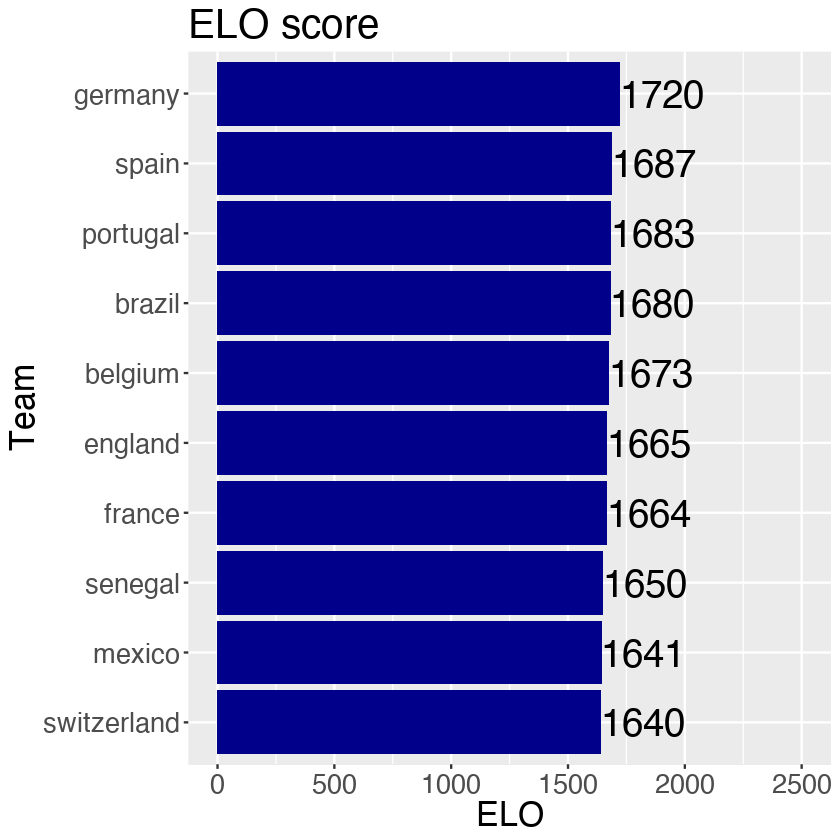

In [15]:
g = ggplot( data = df_plot,aes(x = reorder(team, score), y = score)) + 
  geom_col(fill = 'darkblue') +
  # theme(axis.text.x = element_text(angle = 45)) +
  coord_flip() +
  ylim(0, 2500) +
  geom_text(label = round(df_plot$score),hjust = 0, nudge_y = 0.5, size = 8)+
  labs(x='Team',y='ELO',title = 'ELO score') +
  theme(text = element_text(size=20))

g  

## Final probability calculation
Base on the ELO score above, we can easily predict the odds of the coming fixture in World Cup 2018.

In [16]:
##add win probability
wc_2018 = wc_2018 %>% mutate(
  home_win_prob = 0
)
for (i in 1:nrow(wc_2018)) {
  team1 = as.character(wc_2018[i,'team_1'])
  team2 = as.character(wc_2018[i,'team_2'])
  wc_2018[i,'home_win_prob'] = win_prob(score[which(score$team == team1),2],score[which(score$team==team2),2])
}

wc_2018 = wc_2018 %>%
  # Add in probabilities
  mutate(
    prob_team_1_win = home_win_prob,
    prob_team_1_lose = 1 - prob_team_1_win,
    # Probability bucket for the draw expectation
    prob_bucket = round(20 * abs((prob_team_1_win - prob_team_1_lose))) / 20
  ) %>%
  # Join in draws
  left_join(draw_rates_t) %>%
  # Evenly subtract the draw probability from the home and away probality
  mutate(
    prob_team_1_win = prob_team_1_win - 0.5 * draw_prob,
    prob_team_1_lose = prob_team_1_lose - 0.5 * draw_prob,
    prob_team_1_draw = draw_prob
  )

wc_2018 = wc_2018[,1:7]

wc_2018[,5:7] = round(wc_2018[,5:7],2)

wc_2018_odd = wc_2018 %>%mutate(
  win = round(1/prob_team_1_win,2),
  draw = round(1/prob_team_1_draw,2),
  lose = round(1/prob_team_1_lose,2)
) %>% select(date,match_id,team_1,team_2,win,draw,lose)

score_wc = score %>% filter (team %in% wc_2018$team_1)
score_wc = score_wc[,1:2]




Joining, by = "prob_bucket"



# Result
The following is the odds prediction of World Cup 2018 group stages fixture.

In [17]:
wc_2018

date,match_id,team_1,team_2,prob_team_1_win,prob_team_1_draw,prob_team_1_lose
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
14/06/2018,a_1,russia,saudi arabia,0.57,0.20,0.23
15/06/2018,a_2,egypt,uruguay,0.46,0.25,0.29
15/06/2018,b_1,morocco,iran,0.33,0.27,0.40
15/06/2018,b_2,portugal,spain,0.38,0.24,0.39
16/06/2018,c_1,france,australia,0.47,0.25,0.28
16/06/2018,d_1,argentina,iceland,0.41,0.24,0.35
16/06/2018,c_2,peru,denmark,0.41,0.27,0.32
16/06/2018,d_2,croatia,nigeria,0.47,0.25,0.28
17/06/2018,e_1,costa rica,serbia,0.42,0.24,0.34


## Further

Base on the ELO models and the odds result above, we can perform match simulation by fixed random seed. Hence, obtain the simulated result of group stages. 
Next, further simulations can be performed in the qualifying stage and find the predicted champion.
